In [23]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import numpy as np
import pandas as pd
import time
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim import Adam, SGD, AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, DataCollatorWithPadding
from transformers import BertTokenizer,AutoModel,AdamW,AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm
import copy
import torch.nn as nn
import os
import json
import gc
import random

In [26]:
class CFG:
    input_path = '/content/drive/MyDrive/ccf/'
    model_path = 'hfl/chinese-roberta-wwm-ext' #  nghuyong/ernie-2.0-large-en studio-ousia/luke-large
    scheduler = 'cosine'  # ['linear', 'cosine']
    batch_scheduler = True
    num_cycles = 0.5  # 1.5
    num_warmup_steps = 0
    max_input_length = 1024
    epochs = 5  # 5
    encoder_lr = 20e-6
    decoder_lr = 20e-6
    min_lr = 0.5e-6
    eps = 1e-6
    betas = (0.9, 0.999)
    weight_decay = 0
    num_fold = 5
    batch_size = 20
    seed = 1006
    OUTPUT_DIR = '/content/drive/MyDrive/ccf/'
    num_workers = 2
    device='cuda'
    print_freq = 100

In [27]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(CFG.seed)

## 1. Read Data & EDA

In [28]:
def read_jsonfile(file_name):
    data = []
    with open(file_name) as f:
        for i in f.readlines():
            data.append(json.loads(i))
    return data

train = pd.DataFrame(read_jsonfile(CFG.input_path + "/train.json"))
#add = pd.read_csv('/content/drive/MyDrive/ccf/additional_train.csv')
#train = pd.concat([train, add])
test = pd.DataFrame(read_jsonfile(CFG.input_path + "/testA.json"))
train['label_id'] = train['label_id'].apply(lambda x :int(x))
train.reset_index(inplace=True)

In [29]:
train

,index,id,title,assignee,abstract,label_id
0,0,538f267d2e6fba48b1286fb7f1499fe7,一种信号的发送方法及基站、用户设备,华为技术有限公司,一种信号的发送方法及基站、用户设备。在一个子帧中为多个用户设备配置的参考信号的符号和数据的符...,0
1,1,635a7d4b6358b6ff24a324bb871505db,一种5G通讯电缆故障监控系统,中铁二十二局集团电气化工程有限公司,本发明公开了一种5G通讯电缆故障监控系统，包括信号采样模块、补偿反馈模块，所述信号采样模块对...,0
2,2,aaf98d6bfe1932cf1a262812ca59d1ba,一种测试方法及电子设备,腾讯科技(北京)有限公司,本发明提供了一种测试方法及电子设备，该方法包括：基于选取的测试任务确定目标测试用例，根据所述...,0
3,3,ad49c9ba6412452d9b25071af702f4fb,天线方位角调节装置,武汉虹信通信技术有限责任公司,一种天线方位角调节装置，包括对向的两个8字形支架(101)、动力输入电机(102)、主动齿轮...,0
4,4,ffa2d7617b3eac3a1d7df01e5bb515a2,光纤老化预测方法及装置,新华三大数据技术有限公司,本申请提供一种光纤老化预测方法及装置，所述方法包括：获取待测光纤模块可接收的光信号的告警阈值...,0
...,...,...,...,...,...,...
953,953,6af8c4c55c93ee38b8912db4576b3cfc,一种信息处理方法及装置,腾讯科技(深圳)有限公司,本发明公开了一种信息处理方法，所述方法包括：第一进程获取来自多个查询请求端的多个数据请求，所...,35
954,954,bc94427b0ae4c5a734ef7d32d6a1b9ea,一种适用于安防的广告机,靖江天元爱尔瑞电子科技有限公司,本实用新型公开了一种适用于安防的广告机，包括支撑架，支撑架的上端设置有显示屏，显示屏与壳体配...,35
955,955,2b1d9b24b86b2e49f842bd2c93cb865c,一种广告投放控制方法及装置,阿里巴巴(中国)有限公司,本发明公开了一种广告投放控制方法及装置，以解决现有技术中基于地域定向的广告投放方式准确度较低...,35
956,956,674baad2739c09bc9cc759322a0085c7,一种广告数据推荐方法和系统,北京奇艺世纪科技有限公司,本发明公开了一种广告数据推荐方法和系统。所述方法包括：接收到用户对目标广告数据的浏览请求后，...,35


### 1.1 Label Distribution

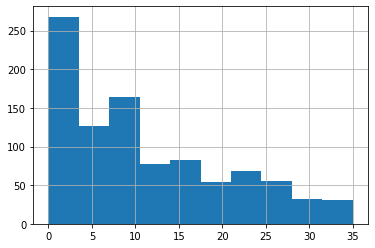

In [30]:
train.label_id.hist()

In [31]:
train.label_id.describe()

count    958.000000
mean      11.140919
std        9.325865
min        0.000000
25%        3.000000
50%        8.000000
75%       17.750000
max       35.000000
Name: label_id, dtype: float64

### 1.2 Input Length Analysis

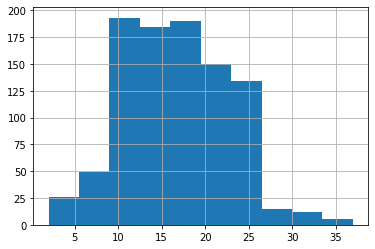

In [32]:
train['title_len'] = train['title'].apply(lambda x: len(x))
train['title_len'].hist()

In [37]:
train['title_len'].describe()

count    958.000000
mean      16.423800
std        6.028142
min        2.000000
25%       12.000000
50%       16.000000
75%       21.000000
max       37.000000
Name: title_len, dtype: float64

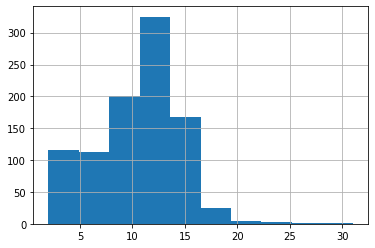

In [36]:
train['assignee_len'] = train['assignee'].apply(lambda x: len(x))
train['assignee_len'].hist()

In [38]:
train['assignee_len'].describe()

count    958.000000
mean      10.494781
std        4.019216
min        2.000000
25%        8.000000
50%       11.000000
75%       13.000000
max       31.000000
Name: assignee_len, dtype: float64

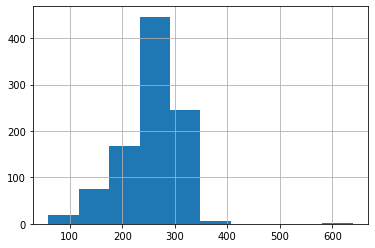

In [39]:
train['abstract_len'] = train['abstract'].apply(lambda x: len(x))
train['abstract_len'].hist()

In [40]:
train['abstract_len'].describe()

count    958.000000
mean     254.092902
std       52.885760
min       59.000000
25%      228.000000
50%      271.000000
75%      291.000000
max      639.000000
Name: abstract_len, dtype: float64

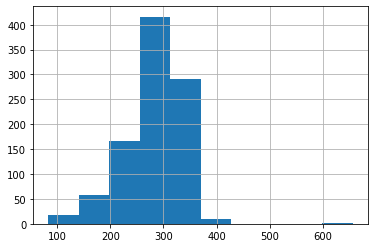

In [35]:
train['input_text'] = train['title'] + train['assignee'] + train['abstract']
train['input_text_len'] = train['input_text'].apply(lambda x: len(x))
train['input_text_len'].hist()

结论：
训练数据较小仅有900条数据，test数据〉2w条，典型小样本训练场景
输入文本长度普遍在350个字以下，超过400的词很少
label的分布也不是很均衡，可能存在较难样本学习不充分的情况

In [ ]:
skf = StratifiedKFold(n_splits=5)
for fold, (_, val_) in enumerate(skf.split(X=train, y=train.label_id, groups=train.label_id)):
    train.loc[val_, "fold"] = int(fold)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


In [ ]:
train.groupby('fold')['label_id'].value_counts()

fold  label_id
0.0   2           544
      10          298
      0           172
      7           150
      8           116
                 ... 
4.0   29            1
      31            1
      32            1
      33            1
      35            1
Name: label_id, Length: 179, dtype: int64

## 2. Build model Input and Dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self,df,tokenizer):
        self.title = df['title'].values
        self.assignee = df['assignee'].values
        self.abstract = df['abstract'].values
        self.label = df['label_id'].values
        self.tokenizer = tokenizer
        self.sep_token = tokenizer.sep_token
    def __len__(self):
        return len(self.title)
    def __getitem__(self, item):
        label = int(self.label[item])
        title = self.title[item]
        assignee = self.assignee[item]
        abstract = self.abstract[item]
        input_text =  title + self.sep_token + assignee + self.sep_token + abstract
        inputs = self.tokenizer(input_text, truncation=True, max_length=400, padding='max_length')
        return torch.as_tensor(inputs['input_ids'], dtype=torch.long), \
               torch.as_tensor(inputs['attention_mask'], dtype=torch.long), \
               torch.as_tensor(label, dtype=torch.long)

## 3. Build Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('hfl/chinese-roberta-wwm-ext',num_labels=36)
tokenizer = AutoTokenizer.from_pretrained('hfl/chinese-roberta-wwm-ext')

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model che

## 4.Build train pipeline

In [ ]:
def get_score(preds, gts):
    return f1_score(preds, gts, average='macro')

In [ ]:
def train_fn(train_loader, model, optimizer, epoch, scheduler, device):
    model.train()
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, batch in enumerate(train_loader):
        label = batch[2].to(device)
        mask = batch[1].to(device)
        input_ids = batch[0].to(device)
        batch_size = label.size(0)
        output = model(input_ids, mask, labels=label)
        loss = output.loss
        losses.update(loss.item(), batch_size)
        optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 500)
        optimizer.step()
        global_step += 1
        scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    return losses.avg

def valid_fn(valid_loader, model, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    labels = []
    start = end = time.time()
    for step, batch in enumerate(valid_loader):
        label = batch[2].to(device)
        mask = batch[1].to(device)
        input_ids = batch[0].to(device)
        batch_size = label.size(0)
        with torch.no_grad():
            output = model(input_ids, mask, labels=label)
        loss = output.loss
        y_preds = output.logits.argmax(dim=-1)
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        labels.append(label.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    labels = np.concatenate(labels)
    return losses.avg, predictions, labels


def train_loop(fold, model, train_dataset, valid_dataset):
    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    #model = Custom_Bert_Simple()
    #model = AutoModelForSequenceClassification.from_pretrained(CFG.model_path, num_labels=1)
    model.to(CFG.device)

    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr,
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        cfg.num_warmup_steps = cfg.num_warmup_steps * num_train_steps
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps,
                num_cycles=cfg.num_cycles
            )
        return scheduler

    num_train_steps = int(len(train_dataset) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = torch.nn.CrossEntropyLoss(ignore_index=- 1)

    # criterion = LabelSmoothingLoss()
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, optimizer, epoch, scheduler, CFG.device)

        # eval
        avg_val_loss, predictions, valid_labels = valid_fn(valid_loader, model, CFG.device)

        # scoring
        score = get_score(predictions, valid_labels)

        elapsed = time.time() - start_time

        LOGGER.info(
            f'Epoch {epoch + 1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch + 1} - Score: {score:.4f}')


        if best_score < score:
            best_score = score
            best_predictions = predictions
            LOGGER.info(f'Epoch {epoch + 1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                       CFG.OUTPUT_DIR + "{}_best{}.pth".format(CFG.model_path.replace('/', '_'),fold))



    torch.cuda.empty_cache()
    gc.collect()
    del scheduler, optimizer, model
    return best_predictions


## 5.Build Logger

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def get_logger(filename=CFG.OUTPUT_DIR+ 'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()
LOGGER.info('===============lr_{}==============='.format(CFG.encoder_lr))
LOGGER.info('===============seed_{}==============='.format(CFG.seed))
LOGGER.info('===============total_epochs_{}==============='.format(CFG.epochs))
LOGGER.info('===============num_warmup_steps_{}==============='.format(CFG.num_warmup_steps))

===============lr_2e-05===============
INFO:__main__:===============lr_2e-05===============
===============seed_1006===============
INFO:__main__:===============seed_1006===============
===============total_epochs_5===============
INFO:__main__:===============total_epochs_5===============
===============num_warmup_steps_0===============
INFO:__main__:===============num_warmup_steps_0===============


In [ ]:
fold = 0
tr_data = train[train['fold']!=fold].reset_index(drop=True)
va_data = train[train['fold']==fold].reset_index(drop=True)
tr_dataset = TrainDataset(tr_data,tokenizer)
va_dataset =TrainDataset(va_data,tokenizer)
val_result = train_loop(fold, model,tr_dataset, va_dataset)

========== training ==========
INFO:__main__:========== training ==========
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [1][0/363] Elapsed 0m 2s (remain 15m 0s) Loss: 3.6682(3.6682) Grad: 10.7638  LR: 0.00002000  
Epoch: [1][100/363] Elapsed 0m 47s (remain 2m 2s) Loss: 0.3283(1.5552) Grad: 3.1495  LR: 0.00001985  
Epoch: [1][200/363] Elapsed 1m 31s (remain 1m 14s) Loss: 0.5031(0.9991) Grad: 14.2149  LR: 0.00001940  
Epoch: [1][300/363] Elapsed 2m 17s (remain 0m 28s) Loss: 0.3651(0.7701) Grad: 13.5713  LR: 0.00001868  
Epoch: [1][362/363] Elapsed 2m 45s (remain 0m 0s) Loss: 0.5432(0.6894) Grad: 8.3376  LR: 0.00001810  
EVAL: [0/46] Elapsed 0m 0s (remain 0m 24s) Loss: 1.0636(1.0636) 


Epoch 1 - avg_train_loss: 0.6894  avg_val_loss: 0.5272  time: 178s
INFO:__main__:Epoch 1 - avg_train_loss: 0.6894  avg_val_loss: 0.5272  time: 178s
Epoch 1 - Score: 0.2813
INFO:__main__:Epoch 1 - Score: 0.2813
Epoch 1 - Save Best Score: 0.2813 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.2813 Model


EVAL: [45/46] Elapsed 0m 12s (remain 0m 0s) Loss: 0.1415(0.5272) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [2][0/363] Elapsed 0m 0s (remain 3m 40s) Loss: 0.3873(0.3873) Grad: 2.1642  LR: 0.00001809  
Epoch: [2][100/363] Elapsed 0m 45s (remain 1m 57s) Loss: 0.1284(0.2015) Grad: 9.5585  LR: 0.00001695  
Epoch: [2][200/363] Elapsed 1m 29s (remain 1m 12s) Loss: 0.0295(0.2085) Grad: 0.4939  LR: 0.00001561  
Epoch: [2][300/363] Elapsed 2m 14s (remain 0m 27s) Loss: 0.2590(0.1945) Grad: 2.2189  LR: 0.00001411  
Epoch: [2][362/363] Elapsed 2m 41s (remain 0m 0s) Loss: 0.2931(0.1896) Grad: 6.1640  LR: 0.00001311  
EVAL: [0/46] Elapsed 0m 0s (remain 0m 20s) Loss: 1.2757(1.2757) 


Epoch 2 - avg_train_loss: 0.1896  avg_val_loss: 0.5060  time: 175s
INFO:__main__:Epoch 2 - avg_train_loss: 0.1896  avg_val_loss: 0.5060  time: 175s
Epoch 2 - Score: 0.4055
INFO:__main__:Epoch 2 - Score: 0.4055
Epoch 2 - Save Best Score: 0.4055 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.4055 Model


EVAL: [45/46] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0223(0.5060) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [3][0/363] Elapsed 0m 0s (remain 3m 37s) Loss: 0.1178(0.1178) Grad: 6.5225  LR: 0.00001309  
Epoch: [3][100/363] Elapsed 0m 45s (remain 1m 57s) Loss: 0.2613(0.1235) Grad: 4.5392  LR: 0.00001141  
Epoch: [3][200/363] Elapsed 1m 29s (remain 1m 12s) Loss: 0.0246(0.1327) Grad: 1.0557  LR: 0.00000969  
Epoch: [3][300/363] Elapsed 2m 14s (remain 0m 27s) Loss: 0.1279(0.1274) Grad: 1.6498  LR: 0.00000798  
Epoch: [3][362/363] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0190(0.1214) Grad: 0.3250  LR: 0.00000694  
EVAL: [0/46] Elapsed 0m 0s (remain 0m 19s) Loss: 1.1919(1.1919) 


Epoch 3 - avg_train_loss: 0.1214  avg_val_loss: 0.4837  time: 175s
INFO:__main__:Epoch 3 - avg_train_loss: 0.1214  avg_val_loss: 0.4837  time: 175s
Epoch 3 - Score: 0.4719
INFO:__main__:Epoch 3 - Score: 0.4719
Epoch 3 - Save Best Score: 0.4719 Model
INFO:__main__:Epoch 3 - Save Best Score: 0.4719 Model


EVAL: [45/46] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0146(0.4837) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [4][0/363] Elapsed 0m 0s (remain 3m 47s) Loss: 0.0126(0.0126) Grad: 0.2520  LR: 0.00000692  
Epoch: [4][100/363] Elapsed 0m 45s (remain 1m 57s) Loss: 0.0155(0.0832) Grad: 0.1667  LR: 0.00000533  
Epoch: [4][200/363] Elapsed 1m 29s (remain 1m 12s) Loss: 0.0138(0.0859) Grad: 0.1584  LR: 0.00000388  
Epoch: [4][300/363] Elapsed 2m 14s (remain 0m 27s) Loss: 0.1539(0.0862) Grad: 2.3258  LR: 0.00000261  
Epoch: [4][362/363] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0196(0.0838) Grad: 0.2606  LR: 0.00000193  
EVAL: [0/46] Elapsed 0m 0s (remain 0m 19s) Loss: 1.1729(1.1729) 


Epoch 4 - avg_train_loss: 0.0838  avg_val_loss: 0.4870  time: 175s
INFO:__main__:Epoch 4 - avg_train_loss: 0.0838  avg_val_loss: 0.4870  time: 175s
Epoch 4 - Score: 0.5064
INFO:__main__:Epoch 4 - Score: 0.5064
Epoch 4 - Save Best Score: 0.5064 Model
INFO:__main__:Epoch 4 - Save Best Score: 0.5064 Model


EVAL: [45/46] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0153(0.4870) 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: [5][0/363] Elapsed 0m 0s (remain 3m 40s) Loss: 0.1152(0.1152) Grad: 4.0198  LR: 0.00000192  
Epoch: [5][100/363] Elapsed 0m 45s (remain 1m 57s) Loss: 0.0129(0.0547) Grad: 0.1314  LR: 0.00000103  
Epoch: [5][200/363] Elapsed 1m 29s (remain 1m 12s) Loss: 0.0123(0.0676) Grad: 0.1807  LR: 0.00000040  
Epoch: [5][300/363] Elapsed 2m 14s (remain 0m 27s) Loss: 0.0155(0.0730) Grad: 0.4399  LR: 0.00000006  
Epoch: [5][362/363] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0875(0.0716) Grad: 3.3004  LR: 0.00000000  
EVAL: [0/46] Elapsed 0m 0s (remain 0m 19s) Loss: 1.1973(1.1973) 


Epoch 5 - avg_train_loss: 0.0716  avg_val_loss: 0.4866  time: 175s
INFO:__main__:Epoch 5 - avg_train_loss: 0.0716  avg_val_loss: 0.4866  time: 175s
Epoch 5 - Score: 0.5014
INFO:__main__:Epoch 5 - Score: 0.5014


EVAL: [45/46] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0110(0.4866) 


## Inference

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.title = df['title'].values
        self.assignee = df['assignee'].values
        self.abstract = df['abstract'].values
        self.tokenizer = tokenizer
        self.sep_token = tokenizer.sep_token

    def __len__(self):
        return len(self.title)

    def __getitem__(self, item):
        title = self.title[item]
        assignee = self.assignee[item]
        abstract = self.abstract[item]
        input_text = title + self.sep_token + assignee + self.sep_token + abstract
        inputs = self.tokenizer(input_text, truncation=True, max_length=400, padding='max_length')
        return torch.as_tensor(inputs['input_ids'], dtype=torch.long), \
               torch.as_tensor(inputs['attention_mask'], dtype=torch.long)

def infer(test_loader, model, device):
    model.to(device)
    model.eval()
    preds = []
    probs = []
    for step, batch in tqdm(enumerate(test_loader)):
        mask = batch[1].to(device)
        input_ids = batch[0].to(device)
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=mask)
        logits = F.softmax(output.logits, dim=-1)
        prob, y_preds = logits.max(dim=-1)
        probs.append(prob.to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())

    predictions = np.concatenate(preds)
    probs = np.concatenate(probs)
    return predictions, probs

saved_path = CFG.OUTPUT_DIR + "{}_best{}.pth".format(CFG.model_path.replace('/', '_'),fold)
model = AutoModelForSequenceClassification.from_pretrained('hfl/chinese-roberta-wwm-ext', num_labels=36)
tokenizer = AutoTokenizer.from_pretrained('hfl/chinese-roberta-wwm-ext')
model.load_state_dict(torch.load(saved_path)['model'])
test_dataset = TestDataset(test, tokenizer)
test_dataloader = DataLoader(test_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
results, probs = infer(test_dataloader, model, CFG.device)
test['label'] = results
test['probs'] = probs
test = test[['id', 'label']]
test.to_csv('submit_A.csv', index=None)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model che